# Download pdf

In [1]:
# Link pdf: https://drive.google.com/file/d/1sFJLWF_RKPHab4F1b0d3a4_4dF-Foz13/view?usp=sharing (Khát Khao Học Máy Machine Learning Yearning - ANDREW NG)
!mkdir -p data
!gdown 1sFJLWF_RKPHab4F1b0d3a4_4dF-Foz13 -O data/MLyearning_vietnamese.pdf


Downloading...
From: https://drive.google.com/uc?id=1sFJLWF_RKPHab4F1b0d3a4_4dF-Foz13
To: /home/khoibui/Projects/Chatbot_RAG/data/MLyearning_vietnamese.pdf
100%|██████████████████████████████████████| 7.30M/7.30M [00:00<00:00, 10.3MB/s]


# Install packages

In [2]:
!pip install -q transformers==4.52.4
!pip install -q bitsandbytes==0.46.0
!pip install -q accelerate==1.7.0
!pip install -q langchain==0.3.25
!pip install -q langchainhub==0.1.21
!pip install -q langchain-chroma==0.2.4
!pip install -q langchain_experimental==0.3.4
!pip install -q langchain-community==0.3.24
!pip install -q langchain_huggingface==0.2.0
!pip install -q python-dotenv==1.1.0
!pip install -q pypdf
!pip install -q tqdm
!pip install -q tiktoken
!pip install -q sentencepiece 
!pip install -q protobuf



# import libraries

In [3]:
import torch

from transformers import BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline

from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.chains import ConversationalRetrievalChain
from langchain_experimental.text_splitter import SemanticChunker


from langchain.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain import hub


/home/khoibui/.conda/envs/chatbot_rag_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read pdf

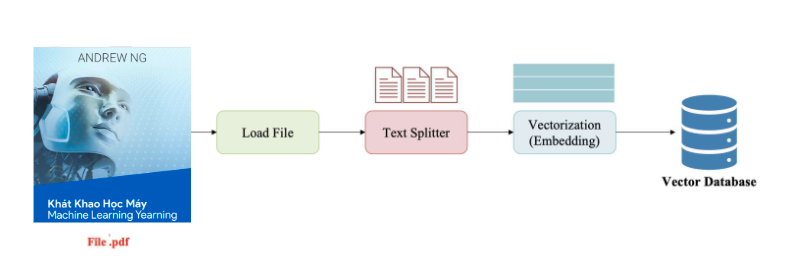

In [4]:
FILE_PATH = "data/MLyearning_vietnamese.pdf"
loader = PyPDFLoader(file_path=FILE_PATH)
documents = loader.load()
print(f"Number of documents: {len(documents)}")


Number of documents: 127


In [5]:
documents[0]


Document(metadata={'producer': 'GPL Ghostscript 9.26', 'creator': 'wkhtmltopdf 0.12.5', 'creationdate': "D:20200104075348Z00'00'", 'moddate': "D:20200104075348Z00'00'", 'title': 'book_vn.md - Grip', 'source': 'data/MLyearning_vietnamese.pdf', 'total_pages': 127, 'page': 0, 'page_label': '1'}, page_content='ANDREW NG\nKhát Khao Học Máy\nMachine Learning Yearning\nChiến lược kỹ thuật cho các kỹ sư AI\ntrong kỷ nguyên Học Sâu\nNhóm Dịch Thuật\nMachine Learning Cơ Bản')

# Initialize text vectorization (embedding)

In [6]:
embeddings_model = HuggingFaceEmbeddings(
    model_name="bkai-foundation-models/vietnamese-bi-encoder"
)


# Intialize text splitter and split documents

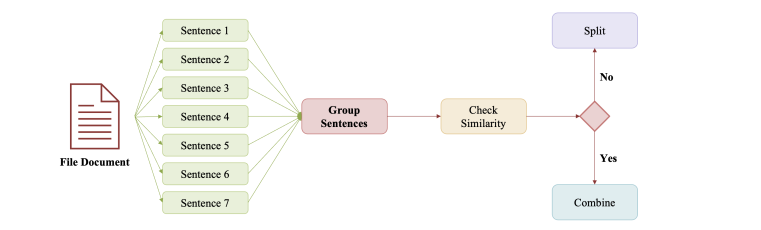

`Semantic Chunking` giúp chia nhỏ văn bản thành các phần có ý nghĩa, giúp tăng tính chính xác khi thực hiện truy vấn. Các tham số trong SemanticChunker giúp điều chỉnh cách thức và cách tách
các đoạn văn bản này:

- **buffer_size=1**: Xác định số câu cần gom lại trước khi tách. Ở đây, giá trị buffer_size=1 có nghĩa là mỗi nhóm bao gồm một câu, giúp mỗi chunk chứa các câu riêng biệt.

- **breakpoint_threshold_type="percentile"**: Tham số này chỉ định cách tính điểm phân đoạn. Trong trường hợp này, percentile có nghĩa là dựa trên tỷ lệ phần trăm của sự khác biệt về ngữ
nghĩa giữa các đoạn văn. Tức là, nếu độ tương đồng của hai đoạn văn thấp hơn ngưỡng nhất định, chúng sẽ được tách ra làm các chunk riêng biệt.

- **breakpoint_threshold_amount=95**: Đây là ngưỡng phần trăm dùng để xác định khi nào nên cắt các đoạn văn bản. Giá trị 95 có nghĩa là nếu độ tương đồng giữa hai đoạn văn thấp hơn 95%, chúng sẽ được tách rời, tạo thành các chunk mới. Điều này đảm bảo rằng các đoạn văn bản không bị cắt ngắt một cách ngẫu nhiên mà vẫn giữ được sự liên kết ngữ nghĩa. 
  
- **min_chunk_size=500**: Thiết lập kích thước tối thiểu của mỗi chunk. Khi giá trị này được đặt thành 500, mỗi đoạn văn bản sẽ có ít nhất 500 ký tự. Điều này đảm bảo rằng các chunk không quá ngắn và vẫn chứa đủ thông tin để có thể sử dụng hiệu quả trong các tác vụ tìm kiếm hoặc truy vấn.

- **add_start_index=True**: Tham số này giúp đánh dấu vị trí của mỗi chunk trong văn bản gốc, tạo chỉ mục cho mỗi phần, giúp dễ dàng tra cứu và tổ chức các chunk sau khi đã được tách ra.

> Với các tham số này, SemanticChunker giúp chia văn bản thành các phần có ý nghĩa và bảo đảm sự liên kết ngữ nghĩa trong mỗi chunk.

# 🎯 Nguyên tắc chung khi chọn Text Splitter (3 yếu tố quyết định:)
1. Loại dữ liệu (PDF, code, chat, email, ...)
2. Cấu trúc văn bản (có cấu trúc rõ vs tự do)
3. Domain kiến thức (kỹ thuật, pháp lý, y tế, ...)

## Chia các Text Splitter thành 3 nhóm theo mức độ phổ biến:

### `Tier 1`: Sử dụng hàng ngày (95% trường hợp)

1. `RecursiveCharacterTextSplitter` (Phổ biến nhất, dùng cho 80% trường hợp):
- Dùng cho:
  -  PDF sách, tài liệu kỹ thuật
  - Báo cáo, bài viết blog
  - Documentation
  - Default choice khi bắt đầu dự án

  ```python
  from langchain_text_splitters import RecursiveCharacterTextSplitter

  splitter = RecursiveCharacterTextSplitter(
      chunk_size=1000,
      chunk_overlap=200,
      separators=["\n\n", "\n", ". ", " ", ""]
  )
  ```
---

2. `CharacterTextSplitter` (Đơn giản, cơ bản nhất):
- Dùng cho:
  - Văn bản đơn giản, đồng nhất
  - Khi cần split nhanh không cần logic phức tạp
  - Prototype/testing

  ```python
  from langchain_text_splitters import CharacterTextSplitter

  splitter = CharacterTextSplitter(
      chunk_size=1000,
      chunk_overlap=200,
      separator="\n\n"
  )
  ```

> Khác RecursiveCharacterTextSplitter: Chỉ dùng 1 separator, không có fallback logic

---

3. `SemanticChunker` (Dùng khi cần split theo ngữ nghĩa):
- Dùng cho:
  - Chat logs, email threads
  - Social media posts
  - Văn bản nhiều chủ đề khác nhau
  - Khi RecursiveCharacterTextSplitter không cho kết quả tốt


  ```python
  from langchain_experimental.text_splitter import SemanticChunker
  from langchain_huggingface import HuggingFaceEmbeddings

  embeddings = HuggingFaceEmbeddings()
  splitter = SemanticChunker(
      embeddings=embeddings,
      breakpoint_threshold_type="percentile"
  )
  ```

---
4. `Code-specific Splitters` (Cho codebase):
- Dùng cho:
  - RAG cho coding assistant
  - Code documentation
  - Repository search

  ```python
  from langchain_text_splitters import (
      Language,
      RecursiveCharacterTextSplitter
  )

  # Python
  python_splitter = RecursiveCharacterTextSplitter.from_language(
      language=Language.PYTHON,
      chunk_size=800,
      chunk_overlap=100
  )

  # JavaScript, Java, C++, Go, Ruby, etc.
  js_splitter = RecursiveCharacterTextSplitter.from_language(
      language=Language.JS,
      chunk_size=800,
      chunk_overlap=100
  )
  ```


###  `Tier 2`: Dùng cho use cases cụ thể (15% trường hợp)
5. `MarkdownHeaderTextSplitter`
- Dùng cho:
  - Markdown documentation (README, wikis)
  - GitHub docs, Notion exports
  - Technical blogs
  ```python
  from langchain_text_splitters import MarkdownHeaderTextSplitter

  splitter = MarkdownHeaderTextSplitter(
      headers_to_split_on=[
          ("#", "Header 1"),
          ("##", "Header 2"),
          ("###", "Header 3"),
      ]
  )
  ```
---
6.`HTMLHeaderTextSplitter`
- Dùng cho:
- Web scraping
- Crawled websites
- HTML documentation        
  ```python   
  from langchain_text_splitters import HTMLHeaderTextSplitter

  splitter = HTMLHeaderTextSplitter(
      headers_to_split_on=[
          ("h1", "Header 1"),
          ("h2", "Header 2"),
          ("h3", "Header 3"),
      ]
  )
  ```
---
7. `SentenceTextSplitter / TokenTextSplitter` 
- Dùng cho:
  - Khi cần control chính xác số tokens (cho LLM API pricing)
  - Fine-tuning models
  - Khi chunk_size phải chính xác
  ```python
  from langchain_text_splitters import SentenceTextSplitter, TokenTextSplitter

  # Sentence-based splitting
  sentence_splitter = SentenceTextSplitter(
      chunk_size=5,  # Số câu mỗi chunk
      chunk_overlap=1
  )

  # Token-based splitting
  token_splitter = TokenTextSplitter(
      chunk_size=100,  # Số token mỗi chunk
      chunk_overlap=20
  )
  ```


## Trade-off cơ bản:
- `RecursiveCharacterTextSplitter` ->   Tốc độ + Kiểm soát  vs    
- `SemanticChunker` -> Chất lượng ngữ nghĩa
                 
   

In [19]:
semantic_splitter = SemanticChunker(
    embeddings=embeddings_model,
    buffer_size=1,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=95,
    min_chunk_size=500,
    add_start_index=True,
    # number_of_chunks= 30,                   # Số chunks mong muốn. Tìm number_of_chunks - 1 điểm có similarity thấp nhất để cắt. Nếu không đủ điểm cắt phù hợp → số chunks thực tế ≠ số chunks mong muốn
    # sentence_split_regex=r'(?<=[.?!…])\s+', # Bao gồm dấu … cho tiếng Việt
)

docs = semantic_splitter.split_documents(documents)
print(f"Number of semantic chunks: {len(docs)}")


Number of semantic chunks: 199


In [20]:
print(docs[0])
print()
print(docs[6])
print()
print(docs[7])


page_content='ANDREW NG
Khát Khao Học Máy
Machine Learning Yearning
Chiến lược kỹ thuật cho các kỹ sư AI
trong kỷ nguyên Học Sâu
Nhóm Dịch Thuật
Machine Learning Cơ Bản' metadata={'producer': 'GPL Ghostscript 9.26', 'creator': 'wkhtmltopdf 0.12.5', 'creationdate': "D:20200104075348Z00'00'", 'moddate': "D:20200104075348Z00'00'", 'title': 'book_vn.md - Grip', 'source': 'data/MLyearning_vietnamese.pdf', 'total_pages': 127, 'page': 0, 'page_label': '1', 'start_index': 0}

page_content='1. Tại sao cần chiến lược Học Máy
Học Máy là nền tảng cho hàng loạt ứng dụng quan trọ ng như tìm kiếm trang web,
lọc thư điện tử spam, nhận dạng giọng nói, gợi ý sả n phẩm, và nhiều ứng dụng khác
nữa. Nếu bạn cùng các thành viên trong nhóm đang là m một dự án học máy và rất
muốn tiến triển nhanh chóng, thì quyển sách này là dành cho bạn. Ví dụ: Xây dựng Startup về ảnh mèo
Giả sử bạn xây dựng công ty khởi nghiệp cung cấp kh ông giới hạn ảnh mèo cho
những người yêu thích. Bạn dùng mạng nơ-ron cho hệ thống thị 

# Remove duplicate chunks

In [ ]:
unique_docs = []
seen = set()

for d in docs:
    content = d.page_content.strip()
    if content not in seen:
        seen.add(content)
        unique_docs.append(d)

docs = unique_docs


In [22]:
print(f"Number of unique semantic chunks: {len(docs)}")


Number of unique semantic chunks: 199


# Create vector database and retriever

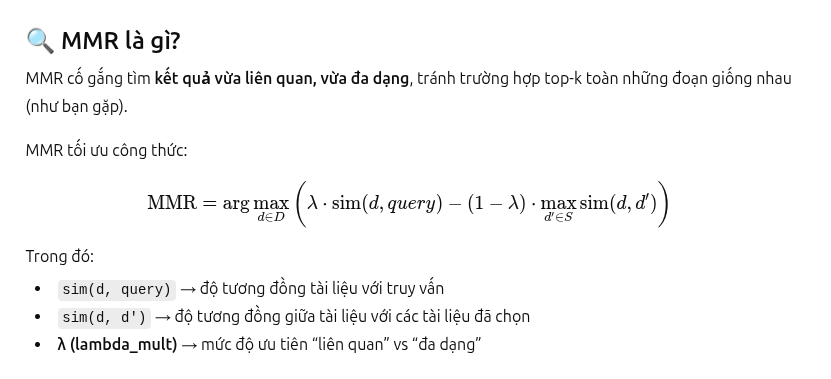

`lambda_mult` trong MMR (Maximal Marginal Relevance) là tham số điều khiển mức độ đa dạng của kết quả trả về khi truy vấn retriever.

| lambda_mult           | Ưu tiên               | Ý nghĩa                                                                |
| --------------------- | --------------------- | ---------------------------------------------------------------------- |
| **1.0**               | 100% relevance        | Giống *similarity search* → lấy đoạn liên quan nhất, nhưng dễ bị trùng |
| **0.8 – 0.6**         | relevance > diversity | Kết quả vẫn sát nghĩa nhưng bớt trùng lặp                              |
| **0.5** (default tốt) | cân bằng              | Vừa liên quan, vừa đa dạng                                             |
| **0.3 – 0.1**         | diversity > relevance | Rất đa dạng nhưng đôi khi ít liên quan                                 |
| **0.0**               | 100% diversity        | Không còn ý nghĩa RAG                                                  |

---

`Cách hiểu “cao → liên quan, thấp → đa dạng”`

Cao (lambda_mult → 1.0) → chọn chunk giống query nhất, nhưng dễ trùng

Thấp (lambda_mult → 0.0–0.3) → chọn chunk khác nhau, tăng đa dạng, giảm trùng nhưng có thể ít liên quan

Vậy mình nói “càng cao càng liên quan” là đúng, nhưng câu trước bạn đọc nhầm thành “càng cao càng trùng” — thực chất trùng hay không phụ thuộc cả similarity của chunks.

Ví dụ: ebook dài, nhiều đoạn gần nghĩa → high lambda vẫn có thể trùng vì chunks tương tự → nên RAG thường dùng ~0.5 để cân bằng liên quan + giảm trùng.

--- 
`Giá trị khuyến nghị cho RAG:`

0.4 – 0.7:

→ Giảm trùng lặp semantic chunks

→ Câu trả lời giàu thông tin hơn

→ Tăng recall

---

lambda_mult `càng cao → tập trung liên quan`

lambda_mult `càng thấp → tập trung đa dạng, tránh lặp`

Với RAG: dùng ~0.5 là tốt nhất, trừ khi dataset đặc biệt.

In [23]:
vector_db = Chroma.from_documents(
    documents=docs,
    embedding=embeddings_model,
    collection_name="ml_yearning_vietnamese",
)

retriever = vector_db.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 8,
        "lambda_mult": 0.7,
    },  # Số k đoạn văn bản liên quan trả về - default 4
)
QUERY = "Hãy giải thích về Độ chệch và Phương sai"
results = retriever.invoke(QUERY)
print("Number of relevant chunks:", len(results))


Number of relevant chunks: 8


In [24]:
for i, doc in enumerate(results):
    print(f"--- Chunk {i+1} ---")
    print(doc.page_content)
    print()


--- Chunk 1 ---
Điều cần nhớ: Phân tích lỗi cơ bản
Phần 3: Độ chệch và Phương sai
20. Độ chệch và Phương sai: Hai nguồn lớn của lỗi
21. Những ví dụ về Độ chệch và Phương sai
22. So sánh với tỉ lệ lỗi tối ưu
23. Xử lý Độ chệch và Phương sai
24. Đánh đổi giữa Độ chệch và Phương sai
25. Kỹ thuật giảm độ chệch có thể tránh được
26. Phân tích lỗi trên tập huấn luyện
27. Các kỹ thuật giảm phương sai
Phần 4: Đồ thị quá trình học
28. Chẩn đoán độ chệch và phương sai: Đồ thị quá trình học
29. Vẽ đồ thị sai số huấn luyện
1

--- Chunk 2 ---
Phần 3: Độ chệch và
Phương sai
37

--- Chunk 3 ---
24. Đánh đổi giữa Độ chệch và Phương sai
Bạn có thể đã nghe về "sự đánh đổi giữa Độ chệch và  Phương sai". Trong các thay
đổi khả dĩ đối với hầu hết các thuật toán học, có m ột số phương pháp giúp giảm sai
số độ chệch nhưng với phải trả giá bằng việc tăng phương sai và ngược lại. Đây là sự
"đánh đổi" giữa độ chệch và phương sai. Ví dụ việc tăng kích thước mô hình -- như thêm các nơ-ron/tầng trong mạng nơ-ron
h

# Load LLMs

In [25]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_type=torch.float16,
)

MODEL_NAME = "lmsys/vicuna-7b-v1.5"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=nf4_config,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=False,
    trust_remote_code=True,
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    pad_token_id=tokenizer.eos_token_id,
    device_map="auto",
)

llm = HuggingFacePipeline(
    pipeline=model_pipeline,
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.29s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Device set to use cuda:0


# **Prompting with RAG**

In [26]:
prompt = ChatPromptTemplate.from_template(
    """
Bạn là một trợ lý AI chuyên về Machine Learning. Nhiệm vụ của bạn là trả lời câu hỏi dựa trên ngữ cảnh được cung cấp.

Hướng dẫn:
- Chỉ sử dụng thông tin từ ngữ cảnh để trả lời
- Nếu ngữ cảnh không chứa thông tin liên quan, hãy nói "Tôi không tìm thấy thông tin này trong tài liệu"
- Trả lời một cách rõ ràng, ngắn gọn
- Sử dụng tiếng Việt tự nhiên

Ngữ cảnh:
{context}

Câu hỏi: {question}

Trả lời:
"""
)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough(),
    }
    | prompt
    | llm
    | StrOutputParser()
)

USER_QUESTION = "Hãy giải thích về Độ chệch và Phương sai ?"
output = rag_chain.invoke(USER_QUESTION)
print(output)


Human: 
Bạn là một trợ lý AI chuyên về Machine Learning. Nhiệm vụ của bạn là trả lời câu hỏi dựa trên ngữ cảnh được cung cấp.

Hướng dẫn:
- Chỉ sử dụng thông tin từ ngữ cảnh để trả lời
- Nếu ngữ cảnh không chứa thông tin liên quan, hãy nói "Tôi không tìm thấy thông tin này trong tài liệu"
- Trả lời một cách rõ ràng, ngắn gọn
- Sử dụng tiếng Việt tự nhiên

Ngữ cảnh:
Điều cần nhớ: Phân tích lỗi cơ bản
Phần 3: Độ chệch và Phương sai
20. Độ chệch và Phương sai: Hai nguồn lớn của lỗi
21. Những ví dụ về Độ chệch và Phương sai
22. So sánh với tỉ lệ lỗi tối ưu
23. Xử lý Độ chệch và Phương sai
24. Đánh đổi giữa Độ chệch và Phương sai
25. Kỹ thuật giảm độ chệch có thể tránh được
26. Phân tích lỗi trên tập huấn luyện
27. Các kỹ thuật giảm phương sai
Phần 4: Đồ thị quá trình học
28. Chẩn đoán độ chệch và phương sai: Đồ thị quá trình học
29. Vẽ đồ thị sai số huấn luyện
1

Phần 3: Độ chệch và
Phương sai
37

định nghĩa Độ chệch và Phương sai. Về mặt kỹ thuật,  những gì tôi định nghĩa là "Độ
chệch" nê

In [27]:
print("[Câu hỏi]:", USER_QUESTION)
answer = output.split("Trả lời:")[1].strip() if "Trả lời:" in output else output.strip()
print("\n[Trả lời]:", answer)


[Câu hỏi]: Hãy giải thích về Độ chệch và Phương sai ?

[Trả lời]: Độ chệch và phương sai là hai nguồn lớn của lỗi trong thuật toán học máy. Độ chệch được định nghĩa là tỉ lệ lỗi của thuật toán trên tập huấn luyện khi tập này rất lớn. Phương sai là tỉ lệ lỗi trên tập kiểm tra so với tập huấn luyện trong thiết lập này. Khi phép đo lỗi là sai số toàn phương trung bình, bạn có thể viết ra công thức để chứng minh được rằng Tổng Lỗi = Độ Chệch + Phương Sai. Bạn có thể đánh đổi giữa độ chệch và phương sai bằng cách tăng kích thước mô hình hoặc thêm dữ liệu vào tập huấn luyện.
